### Implementación de la red neuronal con preprocesamiento GaussianBlur de imágenes suavizadas


Epoch 1: LearningRateScheduler setting learning rate to 0.09000000357627869.
Epoch 1/5
243/243 [==============================] - 389s 2s/step - loss: 0.5307 - accuracy: 0.8012 - val_loss: 2.8268 - val_accuracy: 0.6297 - lr: 0.0900

Epoch 2: LearningRateScheduler setting learning rate to 0.09000000357627869.
Epoch 2/5
243/243 [==============================] - 381s 2s/step - loss: 0.4176 - accuracy: 0.8367 - val_loss: 2.7327 - val_accuracy: 0.5653 - lr: 0.0900

Epoch 3: LearningRateScheduler setting learning rate to 0.09000000357627869.
Epoch 3/5
243/243 [==============================] - 379s 2s/step - loss: 0.3636 - accuracy: 0.8461 - val_loss: 0.4870 - val_accuracy: 0.8290 - lr: 0.0900

Epoch 4: LearningRateScheduler setting learning rate to 0.06300000250339508.
Epoch 4/5
243/243 [==============================] - 379s 2s/step - loss: 0.3171 - accuracy: 0.8637 - val_loss: 0.5196 - val_accuracy: 0.7760 - lr: 0.0630

Epoch 5: LearningRateScheduler setting learning rate to 0.063000001

/home/ale/Documentos/PID/genero_manos/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


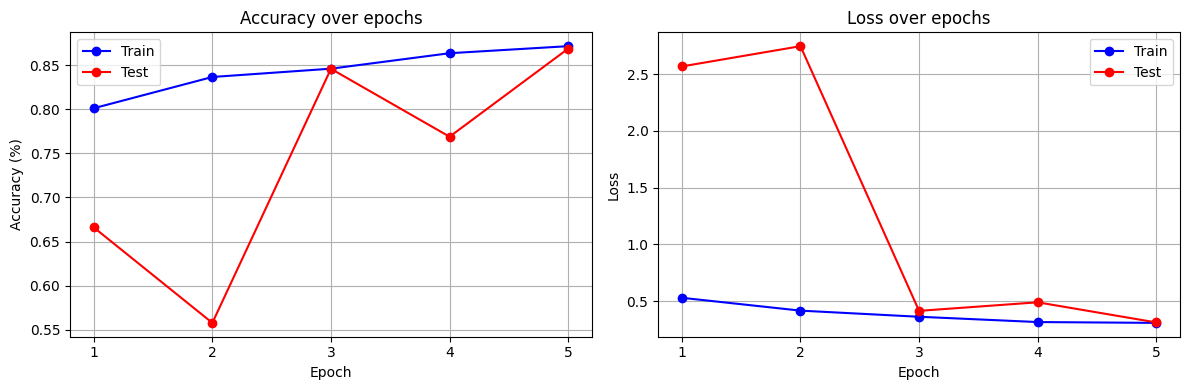

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import SGD

# ================================== Configuración ==================================
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
KERNEL_SIZE = 15

csv_path   = "../../dataset/HandInfo.csv"
image_root = "../../dataset/image"

# ============================== Lectura de etiquetas ================================
df = pd.read_csv(csv_path)
df["label"] = df["gender"].map({"male": 0, "female": 1})
NUM_CLASSES = df["label"].nunique()

# ============================== Normalización Z-score ==============================
def z_score_normalization(image: np.ndarray) -> np.ndarray:
    mean = image.mean()
    std  = image.std()
    return (image - mean) / (std + 1e-7)

# ============================== Preprocesamiento ==============================
def preprocess_image(path_bytes: bytes) -> np.ndarray:
    path = path_bytes.decode("utf-8")
    img  = cv2.imread(path)
    if img is None:
        return np.zeros((*IMG_SIZE, 3), dtype=np.float32)
    img = cv2.resize(img, IMG_SIZE).astype(np.float32)
    img = cv2.GaussianBlur(img, (KERNEL_SIZE, KERNEL_SIZE), 0)
    return z_score_normalization(img)

def tf_preprocess(path, label):
    img = tf.numpy_function(preprocess_image, [path], tf.float32)
    img.set_shape((*IMG_SIZE, 3))
    return img, label

# ============================== Construcción de tf.data.Datasets ==============================
def create_dataset(split_name: str):
    folder = os.path.join(image_root, split_name)
    files  = set(os.listdir(folder))
    subdf  = df[df["imageName"].isin(files)].sort_values("imageName")
    paths  = [os.path.join(folder, fn) for fn in subdf["imageName"]]
    labels = subdf["label"].values
    ds     = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds     = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if split_name == "train":
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset("train")
val_ds   = create_dataset("val")
test_ds  = create_dataset("test")

# ============================== Arquitectura ResNet-light ==============================
def residual_block(x, filters, downsample=False):
    identity = x
    stride   = 2 if downsample else 1

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    return layers.ReLU()(x)

def build_resnet(input_shape=(224,224,3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x      = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False)(inputs)
    x      = layers.BatchNormalization()(x)
    x      = layers.ReLU()(x)
    x      = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    for _ in range(2):
        x = residual_block(x, 64)
    for i in range(3):
        x = residual_block(x, 128, downsample=(i==0))
    for i in range(4):
        x = residual_block(x, 256, downsample=(i==0))
    x      = layers.GlobalAveragePooling2D()(x)
    outputs= layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs)

# ============================== Compilación ==============================
initial_lr = 0.09
optimizer  = SGD(learning_rate=initial_lr, momentum=0.9, decay=0.001)
model      = build_resnet(num_classes=NUM_CLASSES)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ================= Callback: Evaluación sobre test =================
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_dataset):
        super().__init__()
        self.test_ds = test_dataset
        self.test_losses = []
        self.test_accuracies = []
    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_ds, verbose=0)
        self.test_losses.append(loss)
        self.test_accuracies.append(acc)
        print(f"  → Test loss: {loss:.4f} — Test acc: {acc:.4f}")

test_cb = TestMetricsCallback(test_ds)

# ================= Scheduler ajustado =================
def lr_scheduler(epoch, lr):
    if epoch == 3:  # reduce a epoch 4
        return lr * 0.7
    return lr

lr_cb = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

# ================= Entrenamiento =================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[lr_cb, test_cb],
    verbose=1
)

# ================= Guardar modelo =================
model.save("gaussian_model.h5")

# ================= Plot Train vs Test =================
epochs = range(1, len(history.history["accuracy"]) + 1)
train_acc = history.history["accuracy"]
test_acc  = test_cb.test_accuracies
train_loss= history.history["loss"]
test_loss = test_cb.test_losses

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
ax1.plot(epochs, train_acc, marker='o', color='blue', label='Train')
ax1.plot(epochs, test_acc,  marker='o', color='red', label='Test')
ax1.set_title('Accuracy over epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks(epochs)
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(epochs, train_loss, marker='o', color='blue', label='Train')
ax2.plot(epochs, test_loss,  marker='o', color='red', label='Test')
ax2.set_title('Loss over epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(epochs)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()